## Feature Extraction, New and Improved

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from pathlib import Path
from sklearn.metrics import accuracy_score,roc_curve, auc,roc_auc_score

## New attempt (Thursday) with librosa

In [23]:
samples, sample_rate = librosa.load('../../Source/Shuffle/1/1.wav')

**Visualize audio files with librosa**

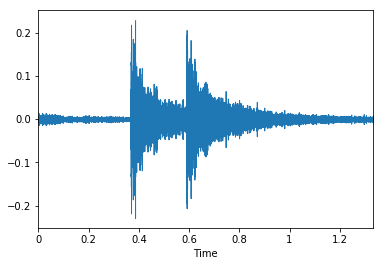

In [24]:
librosa.display.waveplot(samples, sr=sample_rate)

### Feature:
Mel-frequency cepstral coefficients 

In [4]:
n_mfcc = 40   #Remember to change file path at end of nb

In [5]:
# Extract mfcc feature from data
mfccs = np.mean(librosa.feature.mfcc(y=samples, sr=sample_rate, n_mfcc=n_mfcc).T,axis=0) 

In [6]:
len(mfccs)


40

### Repeat for all data (Organize in a DataFrame)

In [7]:
def build_list(step, folder, length):
    i = 1
    step_list = []
    while i <= length :
        name = step + "/" + str(folder) + "/" +str(i) + ".wav"
        step_list.append(name)
        i += 1
    return step_list

def get_label(path):
    if path.parts[-3] == 'Shuffle':
        return 1
    else:
        return 0

In [8]:
shuffle_col, bc_col, path_col = [], [], []

In [9]:
pathlist = Path('../../Source/Shuffle').glob('**/*.wav')
for path in pathlist:
    shuffle_col.append(path)
    shuffle_col.sort()

In [10]:
pathlist = Path('../../Source/Ball_change').glob('**/*.wav')
for path in pathlist:
    bc_col.append(path)
    bc_col.sort()

In [11]:
path_col = shuffle_col + bc_col

In [12]:
tap = pd.DataFrame({'Path':path_col})
tap

,Path
0,../../Source/Shuffle/1/1.wav
1,../../Source/Shuffle/1/2.wav
2,../../Source/Shuffle/1/3.wav
3,../../Source/Shuffle/2/1.wav
4,../../Source/Shuffle/3/1.wav
5,../../Source/Shuffle/4/1.wav
6,../../Source/Shuffle/4/2.wav
7,../../Source/Ball_change/1/1.wav
8,../../Source/Ball_change/1/2.wav
9,../../Source/Ball_change/1/3.wav


In [13]:
tap['Labels'] = [get_label(tap.loc[idx,'Path']) for idx in range(len(tap))]

In [14]:
def get_features(path):
    samples, sample_rate = librosa.load(path)
    mfccs = np.mean(librosa.feature.mfcc(y=samples, sr=sample_rate, n_mfcc=n_mfcc).T,axis=0)
    return mfccs

In [15]:
for i in range (n_mfcc):
    tap[str(i)] = [get_features(tap.loc[idx, 'Path'])[i] for idx in range (len(tap))]

### Feature:
Slope of tangent line between two peaks/beats (from peak_info)
<br/> *Why?* <br/> Shuffles tend to have two sounds that sound alike, hence, slope of 0, and ball-changes have two different sounding sounds. Just an initial idea.

In [16]:
peak_info = pd.read_csv('../../Source/Data/peak_info.csv')
peak_info

,Unnamed: 0,Peak_1,Peak_2,Peak_1_idx,Peak_2_idx,Peak_dist
0,0,32767,32767,16278,26016,9738
1,1,32767,32767,17341,29507,12166
2,2,32767,32767,15455,30247,14792
3,3,32767,32767,7392,17930,10538
4,4,29403,29080,179,28424,28245
5,5,29125,27785,14674,23830,9156
6,6,32767,31129,9086,17849,8763
7,7,25438,32767,5732,16867,11135
8,8,31638,32767,11724,24586,12862
9,9,28943,32767,21934,35041,13107


**Pythagorean theorem** to add "relevant" features w/r/t the two peaks

In [17]:
a2 = peak_info['Peak_dist'].values**2 
b2 = (peak_info['Peak_1'].values - peak_info['Peak_2'].values)**2
c2 = a2 + b2
c = np.sqrt(c2)
cneg = -c
slope = (peak_info['Peak_1'].values - peak_info['Peak_2'].values) / peak_info['Peak_dist'].values
slope

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.01143565,
        0.14635212,  0.18692229, -0.65819488, -0.08777795, -0.2917525 ,
        0.11664046, -0.50217521,  0.0589056 , -0.22825279])

In [18]:
#tap['Slope'] = slope

### Cleaned up data

In [19]:
tap

,Path,Labels,0,1,2,3,4,5,6,7,...,30,31,32,33,34,35,36,37,38,39
0,../../Source/Shuffle/1/1.wav,1,-293.324979,69.916925,-30.826160,2.049414,-4.496487,3.587130,1.109237,-0.926278,...,-5.267698,-0.636060,-5.408465,-0.498015,-4.975301,-0.122819,-4.887241,1.021584,-3.304852,1.667827
1,../../Source/Shuffle/1/2.wav,1,-276.266510,68.263278,-36.615667,5.305029,-5.954178,2.666508,3.021715,-3.797338,...,-4.411695,-0.102422,-4.830428,0.547850,-5.434464,1.211024,-4.144923,1.080524,-3.205386,1.662278
2,../../Source/Shuffle/1/3.wav,1,-274.936810,71.731858,-38.724074,4.732382,-3.488196,2.976912,2.397730,-3.932935,...,-5.081349,0.539130,-3.999879,-0.789776,-5.696328,0.496009,-4.336192,0.904035,-2.891622,1.183886
3,../../Source/Shuffle/2/1.wav,1,-326.417460,112.223266,-44.161899,28.389066,5.440479,10.000289,-1.217789,6.791773,...,-3.366074,-1.519514,-2.083231,1.679214,-1.359012,1.875121,-1.500028,1.136799,-1.029760,0.435550
4,../../Source/Shuffle/3/1.wav,1,-141.855900,26.935705,-72.139592,16.181255,-55.381490,15.658915,-15.245119,3.821122,...,-3.988789,-0.263565,-3.020770,0.935590,-3.086069,0.824559,-2.220420,2.242528,-3.602058,0.658871
5,../../Source/Shuffle/4/1.wav,1,-290.588489,92.319888,4.400158,38.049932,8.649024,13.109860,-4.548680,2.250358,...,-6.727517,-1.897675,-5.501269,-0.453399,-2.505155,-0.385832,-1.733713,0.921764,0.534286,0.553929
6,../../Source/Shuffle/4/2.wav,1,-278.276910,71.938342,-8.494935,39.723621,8.791558,17.675642,-5.919314,2.119934,...,-4.575077,-2.094920,-5.492935,-0.465002,-2.823691,-0.773138,-3.320207,0.811456,-1.373802,1.674202
7,../../Source/Ball_change/1/1.wav,0,-204.499773,82.973693,-30.390968,-6.334111,-3.035847,7.585982,-2.105968,-1.683718,...,-4.993400,-0.086919,-3.773296,-0.218284,-5.648489,-0.959931,-4.590025,-0.780809,-4.500236,-0.014151
8,../../Source/Ball_change/1/2.wav,0,-220.368645,79.751593,-29.200448,-3.312471,-0.492347,5.949044,-0.574927,-4.332889,...,-5.264446,-0.069482,-5.077282,0.190297,-5.276754,-0.020283,-4.167053,-0.820812,-3.576696,-0.563538
9,../../Source/Ball_change/1/3.wav,0,-230.324341,76.424273,-26.476700,-1.124791,-4.272658,4.043409,-4.371823,-3.011313,...,-5.077487,0.195316,-4.761548,-0.122993,-5.988871,-0.334218,-4.825204,-0.426797,-2.567110,-0.337357


In [22]:
#tap.to_csv('../../Source/Data/Tap_test_n40.csv', index=None)